In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Reviews.csv', 'database.sqlite', 'hashes.txt']


In [2]:
reviews_df = pd.read_csv('../input/Reviews.csv', usecols=['HelpfulnessNumerator','HelpfulnessDenominator','Score','Summary','Text'])
print(reviews_df.shape)
reviews_df.head()

(568454, 5)


,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
print(reviews_df.Summary.isnull().sum())
reviews_df = reviews_df.dropna()
print(reviews_df.Summary.isnull().sum())

27
0


In [4]:
reviews_df['Usefulness'] = (reviews_df['HelpfulnessNumerator']/reviews_df['HelpfulnessDenominator']).apply(lambda x:'useful' if x>0.8 else 'useless')
reviews_df = reviews_df.iloc[:,2:]
reviews_df = reviews_df[reviews_df.Score!=3]

In [5]:
reviews_df['Score'] = reviews_df['Score'].apply(lambda x:'pos' if x>3 else 'neg')
reviews_df.head()

,Score,Summary,Text,Usefulness
0,pos,Good Quality Dog Food,I have bought several of the Vitality canned d...,useful
1,neg,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,useless
2,pos,"""Delight"" says it all",This is a confection that has been around a fe...,useful
3,neg,Cough Medicine,If you are looking for the secret ingredient i...,useful
4,pos,Great taffy,Great taffy at a great price. There was a wid...,useless


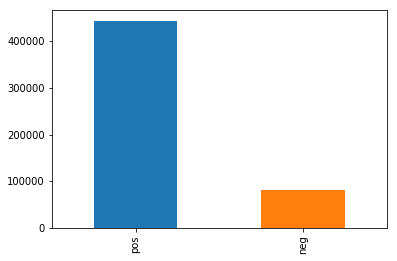

In [6]:
reviews_df.Score.value_counts().plot(kind='bar')

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
vectorizer = CountVectorizer(min_df = 1, ngram_range = (1,4))
X_train_counts = vectorizer.fit_transform(reviews_df.Summary[0:2])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [8]:
X_train_counts.todense()

matrix([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]], dtype=int64)

In [9]:
vectorizer.get_feature_names()

['advertised',
 'as',
 'as advertised',
 'dog',
 'dog food',
 'food',
 'good',
 'good quality',
 'good quality dog',
 'good quality dog food',
 'not',
 'not as',
 'not as advertised',
 'quality',
 'quality dog',
 'quality dog food']

In [10]:
print(len(vectorizer.get_feature_names()))
print(len(X_train_counts.toarray()[0]))

16
16


In [11]:
X_test = vectorizer.transform([reviews_df.Summary[3]])
X_test.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
import gensim
gensim.__version__

'3.6.0'

In [13]:
import re
def preprocessing(content):
    content = content.lower()
    regex = re.compile('[^a-z]')
    #First parameter is the replacement, second parameter is your input string
    return regex.sub(' ', content).strip()

In [14]:
from nltk.tokenize import sent_tokenize, wordpunct_tokenize
def getSentences(docs):
    for doc in docs:
        doc = preprocessing(doc)
        for sent in sent_tokenize(doc):
            yield wordpunct_tokenize(sent)
print(reviews_df.Summary[0],'\n', reviews_df.Summary[1])
print('-'*10)
for sent in getSentences(reviews_df.Summary[:10]):
    print(sent)

Good Quality Dog Food 
 Not as Advertised
----------
['good', 'quality', 'dog', 'food']
['not', 'as', 'advertised']
['delight', 'says', 'it', 'all']
['cough', 'medicine']
['great', 'taffy']
['nice', 'taffy']
['great', 'just', 'as', 'good', 'as', 'the', 'expensive', 'brands']
['wonderful', 'tasty', 'taffy']
['yay', 'barley']
['healthy', 'dog', 'food']


In [15]:
from gensim.models import Word2Vec
min_count = 1
size = 5
window = 3
sentences = list(getSentences(reviews_df.Summary[:2]))
model = Word2Vec(sentences, min_count=min_count, size=size, window=window)
model.wv.vocab.keys()

dict_keys(['good', 'quality', 'dog', 'food', 'not', 'as', 'advertised'])

In [16]:
#update model
new_sentences = list(getSentences(reviews_df.Summary[3:4]))
model.build_vocab(new_sentences, update=True)
model.train(new_sentences, total_examples=model.corpus_count, epochs=model.epochs)


(0, 10)

In [17]:
model.wv.vocab.keys()

dict_keys(['good', 'quality', 'dog', 'food', 'not', 'as', 'advertised', 'cough', 'medicine'])

In [18]:
from gensim.models.phrases import Phrases, Phraser
sentences = list(getSentences(reviews_df.Summary[:2]))

phrases = Phrases(sentences,
                  min_count=2,
                  threshold = 0.5, scoring = 'npmi')
phrase_model = Phraser(phrases)
phrases.vocab

defaultdict(int,
            {b'good': 1,
             b'quality': 1,
             b'good_quality': 1,
             b'dog': 1,
             b'quality_dog': 1,
             b'food': 1,
             b'dog_food': 1,
             b'not': 1,
             b'as': 1,
             b'not_as': 1,
             b'advertised': 1,
             b'as_advertised': 1})

In [19]:
# Get all phrases and there scores in model
sent_phrases = phrases.export_phrases(sentences)
for p in sent_phrases:
    print(p)

In [20]:
# Updating Phraser model
#new_sentences = list(getSentences(reviews_df.Summary[3:4]))
phrases.add_vocab(sentences)
phrase_model = Phraser(phrases)
# Get all phrases and there scores in model
sent_phrases = phrases.export_phrases(sentences)
for p in sent_phrases:
    print(p)

(b'good quality', 0.9999999999999999)
(b'dog food', 0.9999999999999999)
(b'not as', 0.9999999999999999)


In [21]:
def get_phrased_sentences(phrases_model, tokened_sentences):
    for sentence in tokened_sentences: 
        yield phrases_model[sentence]

for s in get_phrased_sentences(phrase_model, sentences):
        print(s)

['good_quality', 'dog_food']
['not_as', 'advertised']


In [22]:
# phrase2vec model
min_count = 1
size = 5
window = 3
sentences = list(get_phrased_sentences(phrase_model, reviews_df.Summary[:2]))
phrase2vec_model = Word2Vec(sentences, min_count=min_count, size=size, window=window)
phrase2vec_model.wv.vocab.keys()

dict_keys(['G', 'o', 'd', ' ', 'Q', 'u', 'a', 'l', 'i', 't', 'y', 'D', 'g', 'F', 'N', 's', 'A', 'v', 'e', 'r'])

# Phrase2vec model for whole corpus

In [24]:
tokened_sentences = list(getSentences(reviews_df.Summary))

In [25]:
def get_phrases(sentences):
    phrases = Phrases(sentences,
                      min_count=2,
                      threshold = 0.5, scoring='npmi')
    return phrases

In [26]:
phrases_full = get_phrases(tokened_sentences)
phrasemodel_full  = Phraser(phrases_full)

In [27]:
for p in phrases_full.export_phrases(tokened_sentences[:10]):
    print(p)

(b'dog food', 0.5409149586490445)
(b'as advertised', 0.6255329943006871)
(b'cough medicine', 0.6247631858057978)
(b'dog food', 0.5409149586490445)


In [28]:
tokened_sentences[:10]

[['good', 'quality', 'dog', 'food'],
 ['not', 'as', 'advertised'],
 ['delight', 'says', 'it', 'all'],
 ['cough', 'medicine'],
 ['great', 'taffy'],
 ['nice', 'taffy'],
 ['great', 'just', 'as', 'good', 'as', 'the', 'expensive', 'brands'],
 ['wonderful', 'tasty', 'taffy'],
 ['yay', 'barley'],
 ['healthy', 'dog', 'food']]

In [29]:
phrased_sentences = list(get_phrased_sentences(phrasemodel_full, tokened_sentences))

In [30]:
min_count = 1
size = 5
window = 3
phrase2vec_full = Word2Vec(phrased_sentences, min_count=min_count, size=size, window=window)


dict_keys(['good', 'quality', 'dog_food', 'not', 'as_advertised', 'delight', 'says', 'it', 'all', 'cough_medicine', 'great', 'taffy', 'nice', 'just', 'as', 'the', 'expensive', 'brands', 'wonderful', 'tasty', 'yay', 'barley', 'healthy', 'the_best', 'hot_sauce', 'in', 'world', 'my', 'cats', 'love_this', 'diet', 'food', 'better_than', 'their', 'regular', 'are', 'fans', 'of', 'new', 'fresh', 'and', 'greasy', 'strawberry', 'twizzlers', 'yummy', 'lots_of', 'what', 'you', 'expect', 'poor', 'taste', 'love', 'sweet', 'candy', 'home', 'delivered', 'twizlers', 'always', 'delicious', 'product', 'please', 'sell', 'these', 'mexico', 'nasty', 'no', 'flavor', 'bargain', 'for', 'price', 'machine', 'this', 'is', 'best', 'instant', 'oatmeals', 'irish', 'oatmeal', 'those', 'a', 'hurry', 'satisfying', 'gluten_free', 's', 'way_to', 'start', 'day', 'wife', 'favorite', 'breakfast', 'why', 'wouldn_t', 'buy', 'from', 'mcanns', 'tastes', 'lovers', 'hot', 'convenience', 'very', 'but', 'next', 'time', 'i', 'won_t'

In [34]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(phrased_sentences)]

In [35]:
# Doc2Vec
doc2vec = Doc2Vec(tagged_documents, vector_size=25, window=5, min_count=3, workers=4)

In [37]:
from gensim.test.utils import datapath
from gensim.models.doc2vec import TaggedLineDocument
for document in TaggedLineDocument(datapath("head500.noblanks.cor")):
    print(document[1])
    break

[0]


# WordCloud

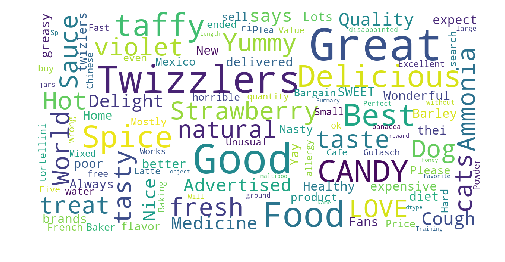

In [38]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(reviews_df.Summary)

**Wordcloud for pos and neg sentences**

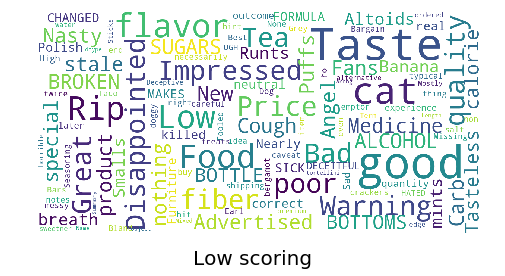

In [39]:
show_wordcloud(reviews_df[reviews_df.Score == 'neg']["Summary"], title = "Low scoring")

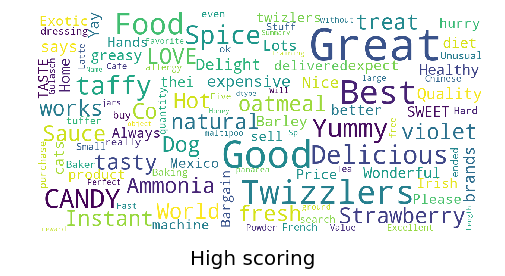

In [40]:
show_wordcloud(reviews_df[reviews_df.Score == 'pos']["Summary"], title = "High scoring")

# Building Text Classification models

In [41]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(reviews_df, test_size=0.2)

In [42]:
# Set train datasets
vectorizer = CountVectorizer(min_df = 1, ngram_range = (1,4))
X_train_counts = vectorizer.fit_transform(train.Summary)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
y_train = train.Score

In [43]:
X_test_tfidf = tfidf_transformer.transform(vectorizer.transform(test.Summary))
y_test = test.Score

In [44]:
prediction = dict()

In [45]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

In [46]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [47]:
X_train_tfidf.shape

(420631, 998972)

In [49]:
def get_phrased_docs(phrase_model, docs):
    tokened_docs = [list(getSentences([doc])) for doc in docs]
    return [list(get_phrased_sentences(phrase_model, tokened_doc)) for tokened_doc in tokened_docs]

docs = train.Summary[:2]
get_phrased_docs(phrase_model, docs)

[[['great', 'soup', 'and', 'easy', 'to', 'make']], [['great', 'color', 'kit']]]

In [50]:
import itertools

def get_docvecs(docs, doc2vec=doc2vec):
    phrased_docs = get_phrased_docs(phrase_model, docs)
    return [list(doc2vec.infer_vector(list(itertools.chain(*doc)))) for doc in phrased_docs]

docs = train.Summary.iloc[:2]
get_docvecs(docs)

[[0.038159464,
  -0.006988726,
  -0.027958311,
  -0.041685686,
  0.0061938344,
  -0.014281127,
  -0.040094547,
  -0.014523582,
  -0.017960949,
  0.07835296,
  0.04967391,
  0.013678279,
  0.015312441,
  0.049537305,
  0.007961189,
  -0.03083618,
  0.03245308,
  0.03856104,
  0.024951616,
  -0.012222999,
  0.013272513,
  -0.00081684877,
  0.041074004,
  -0.03816536,
  0.06403976],
 [-0.0365472,
  -0.04017038,
  0.011151244,
  0.019864023,
  0.0055476828,
  0.00034228538,
  0.0047846218,
  0.027250133,
  0.011492942,
  0.0041753557,
  -0.020000597,
  0.008778337,
  -0.026407776,
  -0.02511303,
  0.006691685,
  -0.009058784,
  0.044165507,
  0.0338829,
  -0.02260395,
  -0.00025953588,
  0.011178525,
  0.018919095,
  -0.031213995,
  -0.01716538,
  0.009445068]]

In [51]:
# doc2vec Log reg model
X_train = get_docvecs(train.Summary)
X_test = get_docvecs(test.Summary)

In [ ]:
len(X_train[0])

In [52]:
doc2vec_lr = LogisticRegression(solver='lbfgs')
doc2vec_lr.fit(X_train, y_train)
prediction['Logistic_vec'] = doc2vec_lr.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
print(metrics.classification_report(y_test, prediction['Logistic_vec'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.58      0.09      0.16     16357
    negative       0.86      0.99      0.92     88801

   micro avg       0.85      0.85      0.85    105158
   macro avg       0.72      0.54      0.54    105158
weighted avg       0.81      0.85      0.80    105158



In [54]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.88      0.84      0.86     16357
    negative       0.97      0.98      0.97     88801

   micro avg       0.96      0.96      0.96    105158
   macro avg       0.93      0.91      0.92    105158
weighted avg       0.96      0.96      0.96    105158



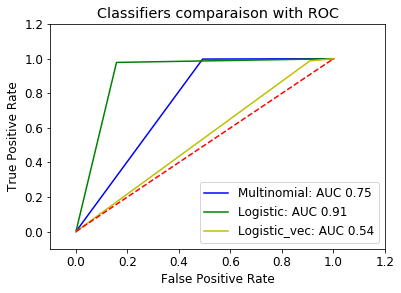

In [55]:
from sklearn.metrics import roc_curve, auc

def formatt(x):
    if x == 'neg':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()